# Charleston Shipping Lanes Risk Analysis

### Research Question

> Presently, there are no recommended lanes off Charleston. Would recommended lane/s reduce the relative risk of interactions between commercial vessels and right whales? Can it be determined?  If so, what is the expected reduction in risk of interactions and where should the lanes be placed? 

### Suggested Approach

Following Fonnesbeck *et al.* (2008), we will construct a predictive model of right whale occurrence that is based on existing aerial survey data and relevant environmental predictors of whale habitat use, such as bathymetry and water temperature. This model will be used as a tool to identify a shipping lane designation that minimizes risk to the migratory northern right whale population.

The metric for risk for a particular lane designation will be the mean probability of co-occurrence of ships and whales over the total area defined by any candidate lane. To avoid having to account for small-scale factors related to the interaction of whales and ships, risk will be estimated at a relatively coarse scale. Specifically, I will estimate the expected occurrence probability of whales over the cells of a 4km grid.

A key component of the modeling approach is the estimation of the probability of occupancy in each grid cell, for a particular month. Occupancy is simply the probability that one or more animals currently occupies a grid cell. Estimates of occupancy are informed by aerial survey data, which includes both sightings and on-watch effort. While a sighting comprises evidence that a grid cell is occupied, the absence of a sighting may indicate either that a cell is not occupied, or that a cell is occupied but the animals were simply not detected by observers.

The probability of one or more detections in a given grid cell $i$ during a given month can be expressed as the complement of the probability of no detections. In turn, the probability of no detections during a given month is the product of the probability of observing no groups ($y_{ij} = 0$) on each survey day $j$. We assume that these daily probabilities are approximately equal, so this is the daily probability $Pr(y_i = 0)$ raised to the number of survey days $n$:

$$\pi_i = 1 - \prod_{j=1}^n Pr(y_{ij}=0) = 1 - [Pr(y_i=0)]^n$$

Encounter probabilities will be estimated for each month of the year, to account for the seasonal migratory movement of whales. To aid the predictive performance of the model, we will use covariates to estimate monthly encounter probabilities; these covariates will include sea surface temperature (SST), bathymetry, as well as month.

An expanded model might additionally include a conditional auto-covariance function for the cells of the habitat grid, allowing information from adjacent grid cells to help inform one another, thereby improving model estimates.

The total risk $r_k$ for a particular lane designation $k$ would then be calculated as:

$$\rho_k = \sum_i \sum_m  \pi_i^{(m)} I(i \in k)$$

where we sum over cells $i=1,\ldots,n$ and months $m=1,\ldots,M$ and $I$ is the indicator function, which returns 1 when the condition is true (in this case, whether cell $i$ is in lane $k$), and zero otherwise.

External constraints on the identification of an optimal line may include factors such as a maximum distance to port and a minimum lane width.

## Data import and cleanup

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import pyproj
from matplotlib.collections import PatchCollection
from descartes.patch import PolygonPatch
from pyproj import Proj, transform
from datetime import date

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
import fiona
from fiona.crs import to_string

from itertools import chain

import urllib

import geopandas as gpd

Import habitat model coverage

In [73]:
with fiona.open('data/HabModelEnviro.shp') as shp:
    
    records = list(shp)
    hab_model_bounds = shp.bounds
    hab_model_json = {"type": "FeatureCollection", "features": records}
    hab_model_crs = shp.crs

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: Read cursor may be altered. This can lead to side effects
  app.launch_new_instance()


In [74]:
epsg26717_str = urllib.request.urlopen('http://spatialreference.org/ref/epsg/26717/proj4/').read().decode("utf-8")
epsg26717_str

'+proj=utm +zone=17 +ellps=clrk66 +datum=NAD27 +units=m +no_defs '

In [75]:
hab_model_crs

{'init': 'epsg:26717'}

In [76]:
wgs84 = Proj(init='EPSG:4326')

In [77]:
hab_model_proj = Proj(hab_model_crs)

Import ship transits to GeoDataFrame

In [78]:
transits = gpd.GeoDataFrame.from_file('data/transits.shp').replace({-999: None})

In [79]:
transits.head()

,CALLSIGN,FLAG,FLAG_TYPE,IMO,LOA,MMSI,NAME,SOV,TR_END,TR_HRS,TR_NMS,TR_PERIOD,TR_RECS,TR_START,TYPE,geometry
0,A8KM7,Liberia (Republic of),Foreign,9344033,183,636013087,Tverskoy Bridge,N,2011-11-01 00:41:35+00,0.68,8.1,2011-2012,18,2011-11-01 00:00:35+00,Tanker,(LINESTRING (-79.37621699999994 32.66900000000...
1,A8OS2,Liberia (Republic of),Foreign,9353266,269,636013695,Ym Elixir,N,2011-11-01 01:07:24+00,1.11,14.6,2011-2012,37,2011-11-01 00:00:46+00,Cargo,(LINESTRING (-79.44591699999995 32.60640000000...
2,WSW6620,United States of America,Domestic,0,18,367061140,Savannah,N,2011-11-01 00:37:12+00,0.61,11.7,2011-2012,28,2011-11-01 00:00:52+00,Pilot,(LINESTRING (-80.78339299999993 31.99384500000...
3,VRGA7,Hong Kong (Special Administrative Region of Ch...,Foreign,9231810,293,477634700,Zim New York,N,2011-11-01 07:45:17+00,7.74,17.3,2011-2012,182,2011-11-01 00:01:10+00,Cargo,(LINESTRING (-79.56774999999993 32.64030000000...
4,None,United States of America,Domestic,0,19,338108309,Lucky Star,N,2011-11-02 11:39:31+00,35.64,3.0,2011-2012,1467,2011-11-01 00:01:12+00,Pleasure,(LINESTRING (-79.75942499999991 32.80539700000...


Import and project habitat model data

In [80]:
HabModelEnviro = gpd.GeoDataFrame.from_file('data/HabModelEnviro.shp').replace({-999: None})

In [81]:
WGS84_crs = urllib.request.urlopen('http://spatialreference.org/ref/epsg/4326/proj4/').read().decode("utf-8")

In [82]:
HabModelEnviroWGS84 = HabModelEnviro.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Truncate to area of interest (31o41' to 33o)

In [83]:
upper_limit = 33
lower_limit = 31.683

In [84]:
HabModelEnviroSC = HabModelEnviroWGS84[(lower_limit < HabModelEnviroWGS84.Lat) & 
                                       (HabModelEnviroWGS84.Lat < upper_limit)]

Import nav channel layer

In [85]:
navchannel = gpd.GeoDataFrame.from_file('data/SHEP_navchannel.shp')

In [86]:
navchannelWGS84 = navchannel.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Set up base map of SC region for visualization

In [87]:
ll = hab_model_bounds[0], hab_model_bounds[1]
ur = hab_model_bounds[2], hab_model_bounds[3]
coords = list(chain(ll, ur))

# Convert to WGS84
coords_wgs = hab_model_proj(*coords[:2], inverse=True) + hab_model_proj(*coords[2:], inverse=True)
w, h = coords_wgs[2] - coords_wgs[0], coords_wgs[3] - coords_wgs[1]

In [88]:
extra = 0.01

basemap_sc = Basemap(ax=None,
    llcrnrlon=-81.5,
    llcrnrlat=lower_limit - extra*w,
    urcrnrlon=-77.5,
    urcrnrlat=upper_limit + extra*w,
    resolution='i',
    epsg='4326')

Example plot of ISO data

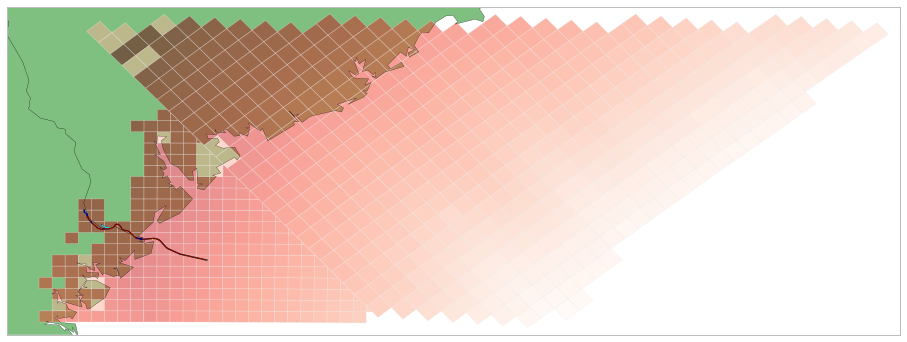

In [89]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelEnviroSC.plot(column='isomar12b', k=5, colormap='Reds', linewidth=0, axes=ax)
navchannelWGS84.plot(column='Color', axes=ax)

Import survey data

In [90]:
HabModelSurvey = gpd.GeoDataFrame.from_file('data/HabModelSurvey.shp')

Reproject to WGS84

In [91]:
HabModelSurveyWGS84 = HabModelSurvey.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Clip to area of interest

In [92]:
HabModelSurveySC = HabModelSurveyWGS84[(lower_limit < HabModelSurveyWGS84.Lat) 
                                       & (HabModelSurveyWGS84.Lat < upper_limit)]

Sample plot of groups sighted for an arbitrary period

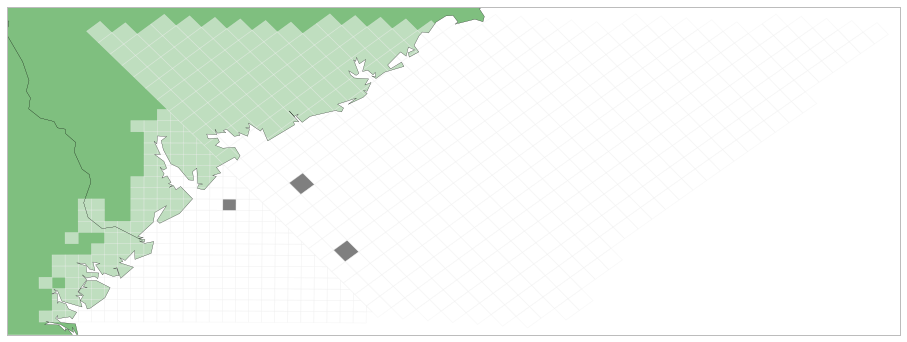

In [93]:
import matplotlib
binary_cm = matplotlib.colors.ListedColormap(np.array([[255,255,255], [0,0,0]])/255)

fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelSurveySC.plot(column='GrpsJan10B', k=2, colormap=binary_cm, linewidth=0, axes=ax)

Perform a merge of survey and habitat data

In [94]:
# Use lower case for trailing A and B times
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelEnviroSC.columns if c.endswith('A') or c.endswith('B')}
HabModelEnviro_points = HabModelEnviroSC.copy().rename(columns=replace_dict)
HabModelEnviro_points.geometry = HabModelEnviro_points.geometry.centroid

In [95]:
from geopandas.tools import sjoin

replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelSurveySC.columns if c.endswith('A') or c.endswith('B')}
HabModel_merged = sjoin(HabModelSurveySC.rename(columns=replace_dict), HabModelEnviro_points, how="left")

In [96]:
# Drop cells with null DistToShor values (land)
HabModel_merged = HabModel_merged.dropna(subset=['DistToShor'])

Buffer distance to shore

In [97]:
HabModel_merged = HabModel_merged[HabModel_merged.DistToShor>1000]

Convert data into long format and remove time information from column names. We are breaking the data into one table for each 2-week period.

In [98]:
time_intervals = ['Dec03a','Dec03b','Dec04a','Dec04b','Dec05a','Dec05b','Dec06a','Dec06b','Dec07a','Dec07b',
         'Dec08a','Dec08b','Dec09a','Dec09b','Dec10a','Dec10b','Dec11a','Dec11b','Dec12a','Dec12b',
         'Feb04a','Feb04b','Feb05a','Feb05b','Feb06a','Feb06b','Feb07a','Feb07b','Feb08a','Feb08b',
         'Feb09a','Feb09b','Feb10a','Feb10b','Feb11a','Feb11b','Feb12a','Feb12b','Feb13a','Feb13b',
         'Jan04a','Jan04b','Jan05a','Jan05b','Jan06a','Jan06b','Jan07a','Jan07b','Jan08a','Jan08b',
         'Jan09a','Jan09b','Jan10a','Jan10b','Jan11a','Jan11b','Jan12a','Jan12b','Jan13a','Jan13b',
         'Mar04a','Mar04b','Mar05a','Mar05b','Mar06a','Mar06b','Mar07a','Mar07b','Mar08a','Mar08b',
         'Mar09a','Mar09b','Mar10a','Mar10b','Mar11a','Mar11b','Mar12a','Mar12b','Mar13a','Mar13b']

data_types = ['Eff', 'Grps', 'Whls', 'iso', 'sst']

In [99]:
months = {'Dec':0, 'Jan':1, 'Feb':2, 'Mar':3}
fortnights = {'a':0, 'b':1}

Create unique cell ID

In [100]:
working_dataset = HabModel_merged.reset_index(level=0).rename(columns={'index':'quad_id'})

Create columns for 2-week period, year and time.

In [101]:
bimonthly_subsets = []
for t in time_intervals:
    # Build column name list
    cols = ['quad_id', 'geometry', 'DistToShor']
    cols += [d+t for d in data_types[:-2]]
    cols += [d+t.lower() for d in data_types[-2:]]
    
    # Remove year time data from column labels
    subset = working_dataset[cols].rename(columns=dict(zip(cols[3:], data_types)))
    
    # Add time data
    month = months[t[:3]]
    year = int(t[3:-1])
    if not month:
        year +=1
    fortnight = fortnights[t[-1]]
    period = month*2 + fortnight
    
    subset['period'] = period
    subset['year'] = year - 3
    subset['time'] = t
    
    bimonthly_subsets.append(subset)

Concatenate subsets into single dataset

In [102]:
working_data_long = pd.concat(bimonthly_subsets, ignore_index=True)

Confirm that the resulting dataset is the same shape

In [103]:
assert sum([b.shape[0] for b in bimonthly_subsets]) == working_data_long.shape[0]

Add centroid coordinates for Gaussian process spatial model

In [104]:
centroids = pd.DataFrame(working_data_long.geometry.apply(lambda x: dict(zip(['lat','lon'], np.ravel(x.centroid.xy)))).tolist(),
            index=working_data_long.index)

In [105]:
working_data_long = working_data_long.join(centroids)

Extract shipping exposure data

In [106]:
transits['start_time'] = pd.to_datetime(transits.TR_START, 'D')

Filter out ineligible transits (Dec-Mar only)

In [107]:
transits = transits[transits.start_time.apply(lambda x: (x.month in (12, 1, 2, 3)) and (x.date()<date(2013, 4, 1)))]

In [108]:
transit_times = transits.start_time.astype(object)

In [109]:
month_lookup = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar'}

In [110]:
transits['time'] = transit_times.apply(lambda t: month_lookup[t.month] + str(t.year)[-2:] + ['a','b'][t.day>14])

Intersect polygons with transits and count transit intersections with each polygon as metric of ship traffic

In [120]:
load_traffic = True

if load_traffic:
    
    working_data_long['traffic'] = pd.read_csv('traffic.csv').values
    
else:
    
    working_data_long['traffic'] = None
    for t in time_intervals:
        lines = [shape(g) for g in transits[transits.time==t].geometry]
        working_data_long.loc[working_data_long.time==t, 'traffic'] = working_data_long[
            working_data_long.time==t].geometry.apply(lambda x: sum([shape(x).intersects(g) for g in lines]))

    working_data_long.traffic.to_csv('traffic.csv')


In [112]:
working_data_long.groupby('year')['Eff'].mean()

year
1        0.000000
2       10.904227
3       14.881509
4        9.418575
5       14.364819
6       19.301899
7       16.616139
8       14.900608
9       19.676070
10      14.953440
Name: Eff, dtype: float64

Drop 2003, given the above, and recode year.

In [113]:
working_data_long['year'] = working_data_long.year - 1
working_data_long = working_data_long[working_data_long.year > 0]

Vessel traffic maps for an arbitrary period

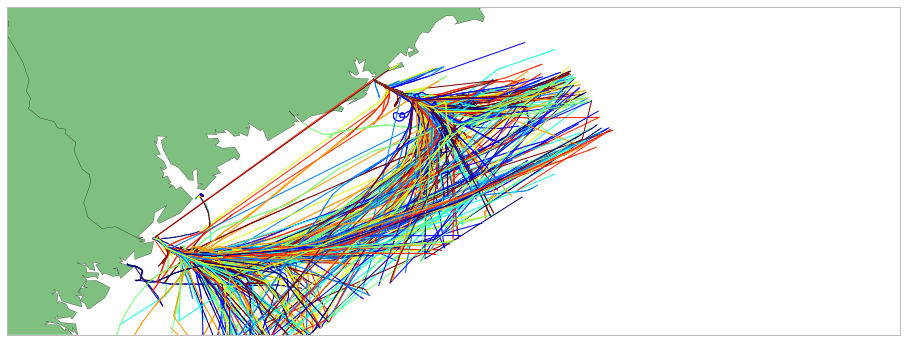

In [115]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

transits[transits.time=='Dec11b'].plot(axes=ax, alpha=0.2)

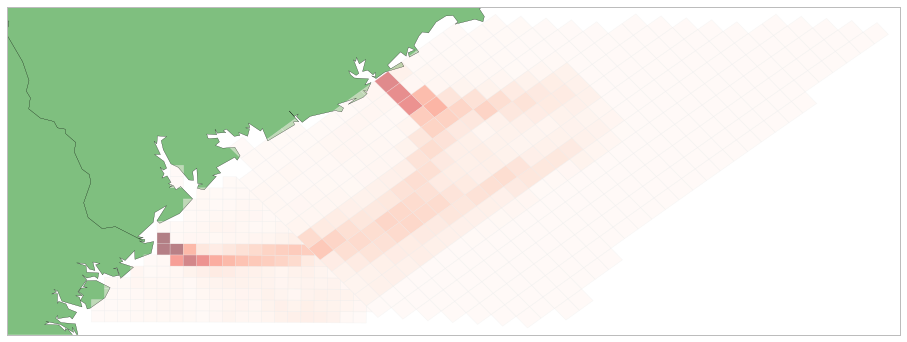

In [114]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

gpd.GeoDataFrame(working_data_long[working_data_long.time=='Jan13a']).plot(column='traffic', 
                                                                           colormap='Reds', linewidth=0, axes=ax)

In [121]:
dataset = working_data_long[~((working_data_long.Eff==0) & (working_data_long.Grps>0)) 
                            & working_data_long.sst.notnull()]

# Include rows with positive effort
not_missing = dataset.Eff>0
dataset_surveyed = dataset[not_missing]
# Rows with zero effort is treated as missing data, to be predicted
missing_data = dataset[~not_missing]
centroids = dataset[['lat', 'lon']].values

In [171]:
df_geo = dataset.groupby('quad_id')

In [172]:
test = dataset[(dataset.year==5) & (dataset.period==5)].copy()
test = test.set_index(test.quad_id)

In [173]:
test['total_groups'] = df_geo['Grps'].sum()
test['mean_effort'] = df_geo['Eff'].mean()

This map shows relative mean survey effort in the region.

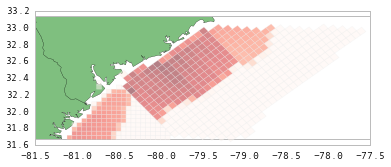

In [174]:
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
gpd.GeoDataFrame(test).plot(column='mean_effort', colormap='Reds', linewidth=0)

## Spatial GLM via Gaussian Process

One of the key features of this analysis is the modeling of spatial autocorrelation via Gaussian processes. Since the number of surveys and sightings are limited, we need to borrow strength among the grid cells of the region, recognizing that an animal observed in one cell is likely to also be in neighboring cells within the same period. The Gaussian process models the spatial covariance directly, here estimating a risk surface of whale occurrence.

In [148]:
from pymc import Normal, Exponential, Uniform, Uninformative, Bernoulli
from pymc import Lambda, MCMC, invlogit, deterministic, AdaptiveMetropolis, MCMC, normal_like, stochastic
from pymc.gp import *

Create mesh of area from grid centroids.

In [149]:
latmin, lonmin = centroids.min(0)
latmax, lonmax = centroids.max(0)
grid = np.meshgrid(np.linspace(lonmin, lonmax), np.linspace(latmin, latmax))
geo_mesh = np.vstack((np.ravel(grid[0]), np.ravel(grid[1]))).T*np.pi/180.

Extract columns of interest from dataset.

In [150]:
(lat, lon, period, year, sst, iso, traffic) = dataset[
    ['lat', 'lon', 'period', 'year', 'sst', 'iso', 'traffic']].values.T
period = period.astype(int)

In [151]:
groups, whales, effort = dataset_surveyed[['Grps', 'Whls', 'Eff']].values.T
year = year.astype(int)
groups = groups.astype(int)
effort = effort/10.

In [152]:
effort.max()

14.985810817999999

Normalize SST and ISO

In [153]:
sst_norm = (sst - sst.mean()) / sst.std()
sst_norm

array([-0.54978739, -0.4295769 , -0.41435712, ...,  0.93511454,
        0.9246915 ,  0.92865033])

In [154]:
iso_norm = (iso - iso.mean()) / iso.std()
iso_norm

array([ 1.14307006,  1.0433865 ,  0.94163143, ..., -0.60293655,
       -0.7406966 , -0.60103156])

The response variable is the sighting of one or more groups.

In [155]:
y = groups > 0

Model constants

In [156]:
nyears = len(set(year))
nperiods = len(set(period))

nyears, nperiods

(9, 8)

This generates a Gaussian process submodel, which we will use to model spatial autocorrelation.

In [157]:
def make_gp_submodel(name, mesh):
    
    # The partial sill.
    amp = Exponential('amp_%s'%name, .1, value=1.)
    
    # The range parameter. Units are RADIANS.     
    scale = Exponential('scale_%s'%name, 1, value=.08)
    
    # 1 radian = the radius of the earth, about 6378.1 km    
    scale_in_km = scale*6378.1
    
    # Create the covariance & its evaluation at the data locations.
    @deterministic(trace=True,name='C_%s'%name)
    def C(amp=amp, scale=scale):
        return FullRankCovariance(exponential.geo_rad, amp=amp, scale=scale)
    
    @deterministic(trace=True, name='M_%s'%name)
    def M():
        return Mean(zero_fn)
    
    GP = GPSubmodel('GP_%s' % name, M, C, mesh=mesh)
    
    return locals()

In [158]:
sst_mesh = np.linspace(sst_norm.min(), sst_norm.max())
iso_mesh = np.linspace(iso_norm.min(), iso_norm.max())

In [183]:
dataset['iso_norm'] = iso_norm

In [184]:
df_grouped = dataset.groupby('quad_id')

In [187]:
iso_mean = df_grouped['iso_norm'].mean()

In [196]:
unique_centroids = df_grouped[['lat', 'lon']].first().values

Here is the hierarchical Bayesian model for whale encounter risk:

In [277]:
def risk_model():
    
    # Year random effect
    sigma_year = Uniform('sigma_year', 0, 1000, value=100)
    tau_year = sigma_year ** -2
    beta_year = Normal('beta_year', 0, tau_year, value=[0]*nyears)

    beta_year_mean = Lambda('beta_year_mean', lambda b=beta_year: b.mean())
    
    # Random walk period effect
    sigma_period = Uniform('sigma_period', 0, 1000, value=100)
    tau_period = sigma_year ** -2
    beta_period = Normal('beta_period', 0, tau_period, value=[0]*nyears)

    beta_period_mean = Lambda('beta_period_mean', lambda b=beta_period: b.mean())

    
    # Quadratic bathymetry effect
    beta_iso = Normal('beta_iso', 0, 0.001, value=[0,0])
    
    spatial_gp = make_gp_submodel('spatial', geo_mesh)
    beta_sp = Lambda('beta_sp', lambda b=spatial_gp['GP'].f(centroids): b)

    # Linear mixed effects model for occurrence
    @deterministic
    def θ(β0=beta_sp, β1=beta_year, β2=beta_period, β3=beta_iso):
        return invlogit(β0 + β1[year-1] + β2[period] + β3[0]*iso_norm + β3[1]*(iso_norm**2)) 
    
    # Probability of detecting one or more groups
    π = Lambda('π', lambda θ=θ: 1.0 - (1.0 - θ[not_missing.values])**effort)
        
    # Likelihood
    occurrence = Bernoulli('occurrence', π, value=y, observed=True)
    
            
    # Predicted probability of encounter
    @deterministic
    def p_pred(β0=spatial_gp['GP'].f(unique_centroids), β1=beta_year_mean, β2=beta_period_mean, β3=beta_iso):
        return invlogit(β0 + β1 + β2 + β3[0]*iso_mean.values + β3[1]*(iso_mean.values**2)) 
    
    risk = Lambda('risk', lambda theta=θ: theta*traffic)
               
    return locals()

Instantiate and run MCMC model

In [278]:
M = MCMC(risk_model())
M.use_step_method(AdaptiveMetropolis, M.beta_year)
M.use_step_method(AdaptiveMetropolis, M.beta_period)

In [279]:
import appnope
appnope.nope()
M.sample(20000, 10000)

 [-----------------100%-----------------] 20001 of 20000 complete in 27442.9 sec

## Model output

The following graphical summaries show the posterior distribution of key parameters.

Estimated isotherm effect:

Plotting beta_iso_0
Plotting beta_iso_1


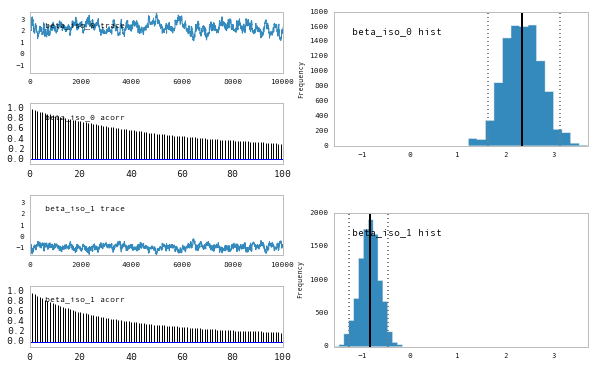

In [280]:
from pymc import Matplot

Matplot.plot(M.beta_iso)

Gaussian process hyperparameters

Plotting amp_spatial


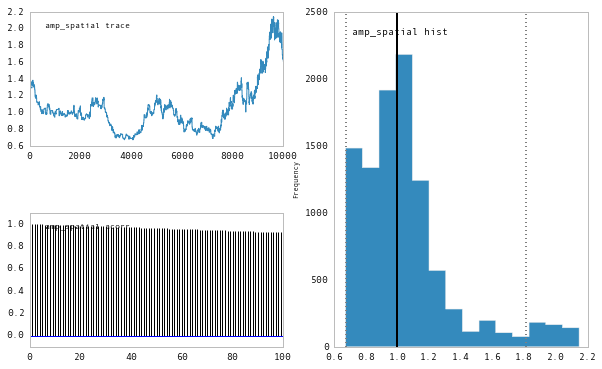

In [281]:
Matplot.plot(M.spatial_gp['amp'])

2-week period effects

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


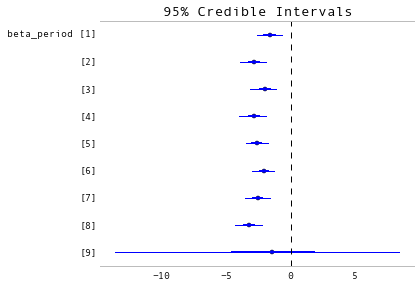

In [282]:
Matplot.summary_plot(M.beta_period)

Year effects

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


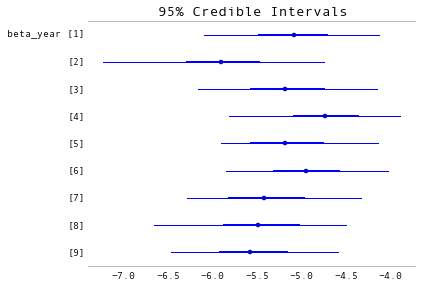

In [283]:
Matplot.summary_plot(M.beta_year)

In [ ]:
dataset['risk'] = M.risk.stats()['mean']

In [ ]:
dataset['p_pred'] = invlogit(M.θ.stats()['mean'])

In [169]:
dataset['gp_mean'] = M.beta_sp.stats()['mean']

This is an illustration of the Gaussian process, showing the spatial autocorrelation. 

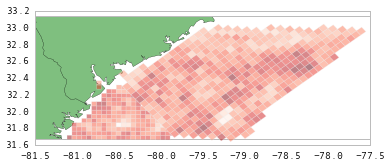

In [170]:
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
gpd.GeoDataFrame(dataset[(dataset.year==5) & (dataset.period==5)]).plot(column='gp_mean', colormap='Reds', 
                                                                        linewidth=0)

In [208]:
period_labels = ['%s %s' % (period, month) for month in ('December', 'January', 'February', 'March') 
                 for period in ('Early', 'Late')]

In [271]:
def plot_year_by_month(year, column='p_pred', cmap='Reds'):

    f, axes = plt.subplots(4, 2, figsize=(12, 14))
    
    vmax = gpd.GeoDataFrame(dataset[(dataset.year==year)])[column].max()

    for i,ax in enumerate(axes.ravel()):
        basemap_sc.drawstates(linewidth=0.15, ax=ax)
        basemap_sc.drawcoastlines(linewidth=0.25, ax=ax)
        basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5, ax=ax)
        gpd.GeoDataFrame(dataset[(dataset.year==year) & (dataset.period==i)]).plot(column=column, 
                                                                                colormap=cmap, vmin=0, #vmax=vmax,
                                                                                linewidth=0, axes=ax)
        ax.set_title(period_labels[i])
        
    f.suptitle('Winter %s/%s' % (2003+year, 2004+year), fontsize=16)
    f.tight_layout()

This map shows predicted probabilities of sightings across the region.

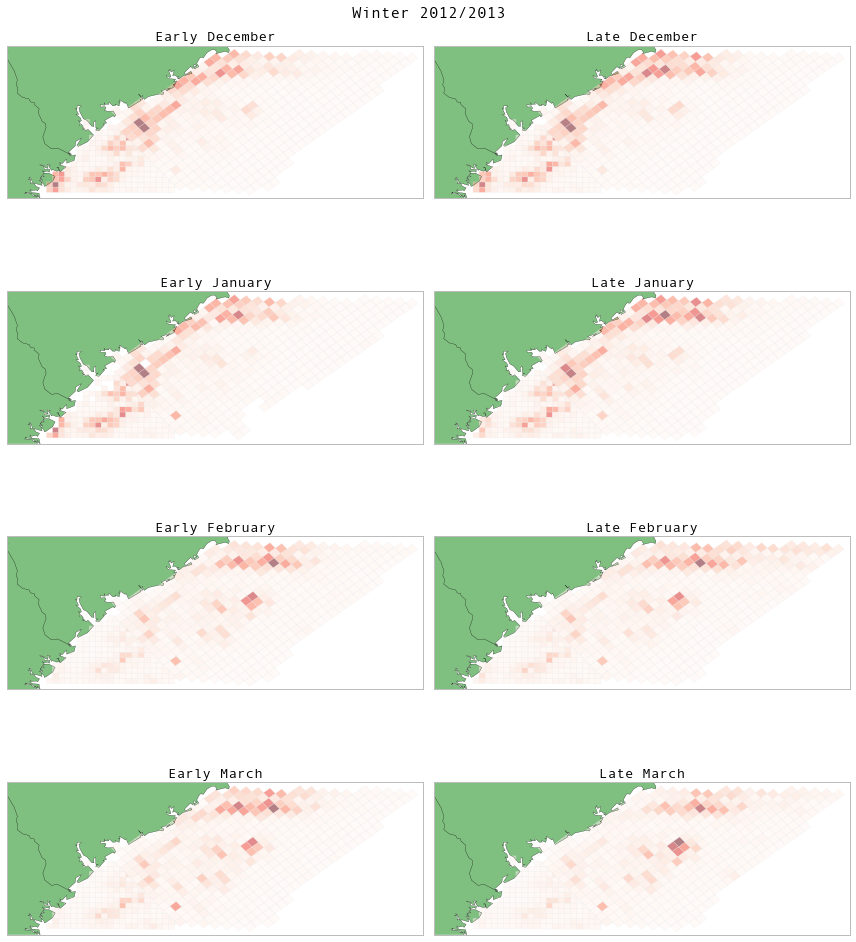

In [275]:
plot_year_by_month(9, 'p_pred')

This map combines predicted probabilities with ship traffic, to create a risk surface, for a given year.

In [268]:
dataset['risk'] = dataset.p_pred * dataset.traffic

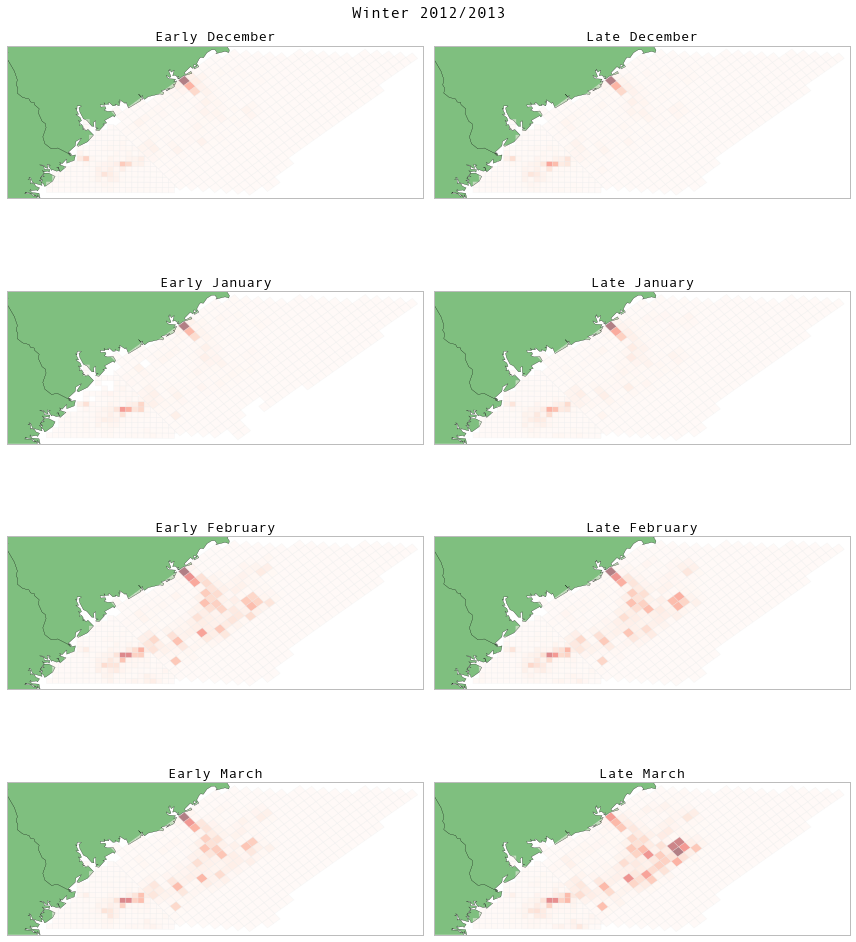

In [276]:
plot_year_by_month(9, 'risk')

In [241]:
grouped_index = df_grouped['risk'].sum().index

In [232]:
p_pred = M.p_pred.stats()['mean']

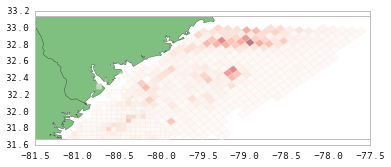

In [264]:
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
subset = dataset[(dataset.year==9) & (dataset.period==2)].set_index('quad_id')
geo_subset = gpd.GeoDataFrame(pd.concat([subset, pd.Series(p_pred, index=grouped_index)], axis=1, join='inner'))
geo_subset.plot(column=0, colormap='Reds', linewidth=0)


## Status and next steps

The estimates above are still preliminary, and the model is still a work in progress. However, the core of the model is now in place, pending model checks, and we can move to the process of selecting appropriate lanes given the predictions of the model. 

Questions:

- what is the appropriate width of the lane?
- is there a particular configuration that the lane should have? For example, should there be a Northern and Southern approach, to accomodate the types of traffic patterns that we see in the extant data?
- should the lanes be static, or temporally dynamic? I assume there would not be much appetite for lanes that change through the season?